In [1]:
# https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
# https://www.tensorflow.org/decision_forests/tutorials/predict_colab
# https://www.tensorflow.org/decision_forests/tutorials/automatic_tuning_colab
# https://www.tensorflow.org/decision_forests/tutorials/advanced_colab 

from google.cloud import bigquery

import pandas as pd
import numpy as np

import math
import os

import tensorflow as tf
print(tf.__version__)

2023-07-07 14:53:46.210826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarni

2.12.0


In [2]:
#pip install tensorflow_decision_forests --upgrade --user
import tensorflow_decision_forests as tfdf
print(tfdf.__version__)

1.4.0


# Variable to Configuration

In [4]:
model_tree_type=1# 1= xgboost  2-random forest
option_cate_feature=1

labelCol='label_multi_severity'
# labelCol='label_binary_severity'

In [5]:
projectId='pongthorn'
dataset_id='SMartML'

train_name='train2_incident'
test_name='test2_incident'

train_table_id=f"{projectId}.{dataset_id}.{train_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"train-ds = {train_table_id}")
print(f"test-ds = {test_tabel_id}")

train-ds = pongthorn.SMartML.train2_incident
test-ds = pongthorn.SMartML.test2_incident


In [6]:
metric="accuracy"

if model_tree_type==1:
    _model='model_xgb_tf'
else:
     _model='model_rf_tf'

model_gs_path=f"gs://demo-tuned-tf-incident-pongthorn/{_model}"
print(model_gs_path)
#model_local_path=_model

gs://demo-tuned-tf-incident-pongthorn/model_xgb_tf


In [7]:

if option_cate_feature==1:
    # cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour','range_response_to_resolved_hour']
    cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour']
    numbericCols=[]
    #unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour','response_to_resolved_hour']
    unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour']
else:
    cateCols=['sla','product_type','brand','service_type','incident_type']
    numbericCols=['open_to_close_hour']
    unusedCols=['id','severity_id','severity_name','label_binary_severity','range_open_to_close_hour']




# Load & Prepare Data

In [8]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64') 
 df=df[[labelCol]+cateCols+numbericCols]   
  
 return df

In [9]:
client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

print(train.info())

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2241 entries, 0 to 2240
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   label_multi_severity      2241 non-null   int64 
 1   sla                       2241 non-null   object
 2   product_type              2241 non-null   object
 3   brand                     2241 non-null   object
 4   service_type              2241 non-null   object
 5   incident_type             2241 non-null   object
 6   range_open_to_close_hour  2241 non-null   object
dtypes: int64(1), object(6)
memory usage: 122.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   label_multi_severity      561 non-null    int64 
 1   sla                       561 non-null    object
 2   product_type              

In [10]:
classes_train = list(train[labelCol].unique())
classes_test = list(test[labelCol].unique())

set_classes=set(classes_train) & set(classes_test)
classes=list(set_classes)
classes

[0, 1, 2, 3]

In [11]:
train.tail(5)

,label_multi_severity,sla,product_type,brand,service_type,incident_type,range_open_to_close_hour
2236,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Configuration Change,soonest
2237,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,OS / Firmware,latest
2238,0,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,soonest
2239,0,24x7 4Hrs Response Time,Security,Trend Micro,Request,Upgrade Software,fair
2240,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,soonest


In [12]:
test.tail()

,label_multi_severity,sla,product_type,brand,service_type,incident_type,range_open_to_close_hour
556,0,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Request,Software,late
557,3,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,soonest
558,1,24x7 4Hrs Response Time,Software,Trend Micro,Request,Software,late
559,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,soon
560,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,soon


# Build Model

In [13]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=labelCol)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=labelCol)

In [14]:
# Specify the model.
if model_tree_type==1:
    print("GradientBoostedTreesModel")
    model=tfdf.keras.GradientBoostedTreesModel()
else:
    print("RandomForestModel")
    model = tfdf.keras.RandomForestModel()

model.fit(x=train_ds)

GradientBoostedTreesModel
Use /var/tmp/tmp8lcik4c_ as temporary training directory
Reading training dataset...


[WARNING 23-07-07 14:55:14.0983 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-07 14:55:14.0991 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-07 14:55:14.0993 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-07-07 14:55:14.205313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2241]
	 [[{{node Placeholder/_2}}]]


Training dataset read in 0:00:04.582684. Found 2241 examples.
Training model...
Model trained in 0:00:00.341295
Compiling model...


[INFO 23-07-07 14:55:19.0234 UTC kernel.cc:1243] Loading model from path /var/tmp/tmp8lcik4c_/model/ with prefix 3ac63f3679524a2a
[INFO 23-07-07 14:55:19.0839 UTC decision_forest.cc:660] Model loaded with 148 root(s), 7318 node(s), and 6 input feature(s).
[INFO 23-07-07 14:55:19.0848 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-07-07 14:55:19.0853 UTC kernel.cc:1075] Use fast generic engine
2023-07-07 14:55:19.134495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype string and shape [2241]
	 [[{{node Placeholder/_3}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [15]:
model.compile(metrics=[metric])
evaluation = model.evaluate(test_ds, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

2023-07-07 14:55:21.307552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [561]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 411ms/step - loss: 0.0000e+00 - accuracy: 0.7005
loss: 0.0000
accuracy: 0.7005


# Model Summary
## Model structure and feature importance

In [16]:
#model_detail=model.summary()
model.make_inspector().variable_importances()
# SUM_SCORE ,NUM_AS_ROOT

{'SUM_SCORE': [("service_type" (4; #5), 1362.6787708219756),
  ("brand" (4; #1), 806.0843573779655),
  ("incident_type" (4; #2), 553.010785214987),
  ("sla" (4; #6), 233.9900549257477),
  ("product_type" (4; #3), 206.88513010378165),
  ("range_open_to_close_hour" (4; #4), 171.18086536869487)],
 'NUM_NODES': [("incident_type" (4; #2), 1053.0),
  ("brand" (4; #1), 854.0),
  ("range_open_to_close_hour" (4; #4), 581.0),
  ("sla" (4; #6), 466.0),
  ("product_type" (4; #3), 450.0),
  ("service_type" (4; #5), 181.0)],
 'INV_MEAN_MIN_DEPTH': [("incident_type" (4; #2), 0.3849568498156877),
  ("brand" (4; #1), 0.34223006001996),
  ("service_type" (4; #5), 0.3040375450057004),
  ("product_type" (4; #3), 0.2583184820129492),
  ("sla" (4; #6), 0.21723119307292227),
  ("range_open_to_close_hour" (4; #4), 0.21416562596709304)],
 'NUM_AS_ROOT': [("service_type" (4; #5), 69.0),
  ("brand" (4; #1), 35.0),
  ("incident_type" (4; #2), 31.0),
  ("product_type" (4; #3), 10.0),
  ("range_open_to_close_hour" 

# Model Self Evaluation

In [17]:
model.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=0.7150259017944336, loss=0.6810050010681152, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

# Plotting the training logs

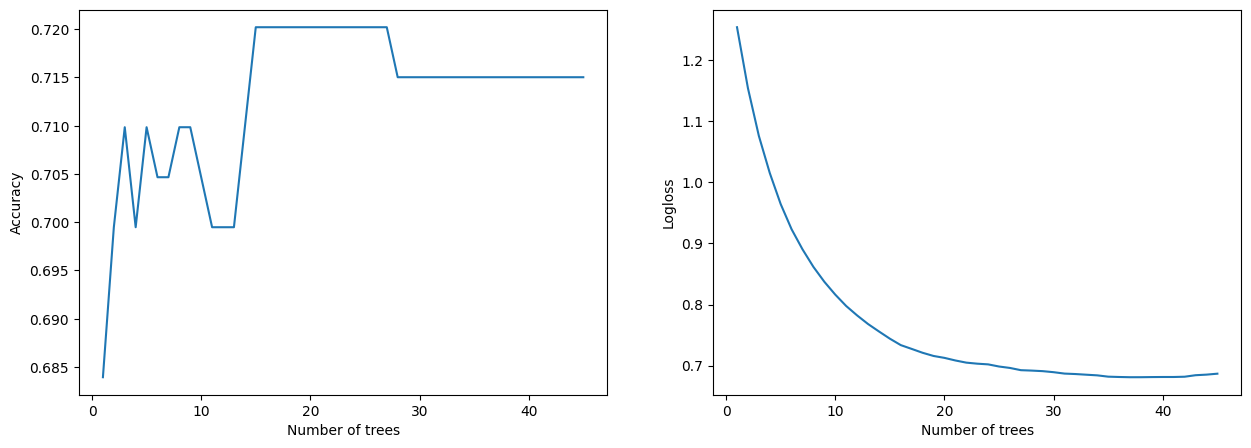

In [18]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss")

plt.show()

# Plot the model

In [19]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

# Save Model

In [20]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/distribute/save_and_load.ipynb#scrollTo=jFcuzsI94bNA
#save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
# model.save(model_gs_path,options=save_options)
# model.save(model_local_path,options=save_options)
model.save(model_gs_path)

INFO:tensorflow:Assets written to: gs://demo-tuned-tf-incident-pongthorn/model_xgb_tf/assets


INFO:tensorflow:Assets written to: gs://demo-tuned-tf-incident-pongthorn/model_xgb_tf/assets
